In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.3, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t


Encoding midi-data
 500
> -> multi-track = True none
 [INFO] : 
 |  True


In [6]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../datasets/

In [8]:
genres[0][-2:]

["01 Rock'n'Roll", '01 Dancin Rick 166BPM']

In [9]:
dn = config.dataset_dir + 'drum_midi/' + '50´s Drummer MIDI Files'
# for a in os.walk(config.dataset_dir + 'drum_midi'):
#     print(a)
sorted(os.listdir(dn))

['.DS_Store',
 "01 Rock'n'Roll",
 '02 Blues',
 '03 Traditional Pop',
 '04 Country',
 '05 Jazz',
 '06 Soul - Funk',
 '07 Indie']

In [10]:
unique_genres = set(genre[-2] +'/'+ genre[-1] for genre in genres)
len(unique_genres)

72

In [11]:
unique_genres

{"01 Rock'n'Roll/01 Dancin Rick 166BPM",
 "01 Rock'n'Roll/02 Gogo 191BPM",
 "01 Rock'n'Roll/03 Lips n Hips 152BPM",
 "01 Rock'n'Roll/04 Maybelline 233BPM",
 "01 Rock'n'Roll/05 Straight Line 136BPM",
 "01 Rock'n'Roll/06 Moonglow 140BPM",
 "01 Rock'n'Roll/07 Thwag 170BPM",
 "01 Rock'n'Roll/08 Doowoop 140bpm",
 "01 Rock'n'Roll/09 Diddeley 185bpm",
 "01 Rock'n'Roll/10 Ottis 172bpm",
 '02 Blues/01 Booze 92BPM',
 '02 Blues/02 Nappy Brown 160BPM',
 '02 Blues/03 Noton Bull 192BPM 12-8 Brushes',
 '02 Blues/04 Mickeys 212BPM 12-8',
 '02 Blues/05 Cadillac 128BPM',
 '02 Blues/06 Vidar Vega 70BPM',
 '02 Blues/07 Straight 88BPM',
 '02 Blues/08 Sams 127BPM',
 '02 Blues/09 Leroyes 130BPM',
 '02 Blues/10 Bogeart 122BPM',
 '03 Traditional Pop/01 Fly High 115BPM',
 '03 Traditional Pop/02 Frankies Girl 116BPM',
 '03 Traditional Pop/03 King Quiza 102BPM',
 '03 Traditional Pop/04 Love 155BPM',
 '03 Traditional Pop/05 Your Eyes 80BPM',
 '03 Traditional Pop/06 Bopop 130MPM',
 '03 Traditional Pop/07 Lester Lee

In [12]:
x_train.shape

(500, 160, 10, 1)

In [13]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
genre_dict = setup.build_label_dict(genres, min_samples=7)

In [14]:
n_samples_per_genre = [len(items) for items in genre_dict.values()]
for f in [min, max, np.mean, np.median]:
    print(f, f(n_samples_per_genre))
len(n_samples_per_genre)

<built-in function min> 7
<built-in function max> 7
<function mean at 0x10acf6f28> 7.0
<function median at 0x10ae2ad08> 7.0


71

In [15]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [16]:
latent_dim = 10
epsilon_std = 1.0

In [17]:
vae, encoder, generator = models.build(input_shape, latent_dim)

/usr/local/lib/python3.6/site-packages/keras/layers/core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `[(None, 10), (None, 10)]` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/Users/mark/src/pattern-recognition/src/models.py:147: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.
  vae.compile(optimizer='adam')


In [18]:
batch_size = 128
epochs = 500
params = {'batch_size': batch_size, 'return_y': False}

In [19]:
# phase_mod = 0.01
# whitening = False

In [20]:
name = 'non-functional_model.h5'
fn = config.model_dir + name

In [21]:
# io.save_dict('../logs/','train_loss', history)

In [22]:
# # for suffix, model in [('vae',vae), ('encoder',encoder), ('gen',generator)]:
# #     model.save_weights(dn + prefix + suffix + '.h5', "w")
# vae.save_weights(fn, "w")

In [23]:
vae.load_weights(fn)

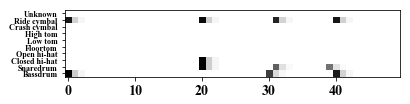

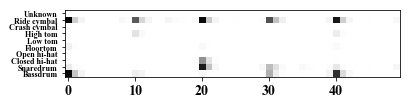

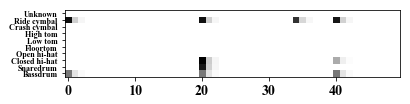

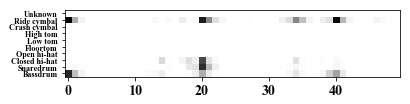

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [24]:
i,j = 240, 30
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

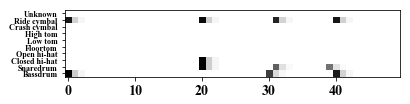

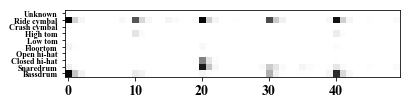

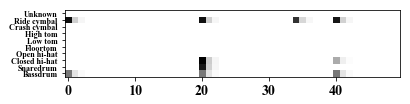

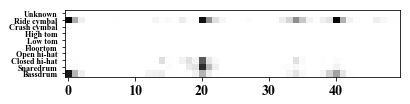

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [25]:
i,j = 0, 10
i,j = 240, 30

m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

In [26]:
decoder = generator

## Style transfer

In [27]:
m = 500
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(500, 10)

In [28]:
# a = list({3:[2],'s':[3,3]}.keys())
# np.random.shuffle(a)
# a

In [85]:
import transformation_extraction

In [86]:
utils.reload(transformation_extraction)
best_dims, importances, transformations, min_transformations = \
    transformation_extraction.between_genres(x_train_encoded, genre_dict, amt1=1000, amt2=20, v=1)

Warning, amt too high 1000 71
Genre A: 04 Country/01 Calvin 148BPM
  genre B: 	03 Traditional Pop/09 Distel 155BPM (len: 7)
 	 i: 0, importance: 0.311489
  genre B: 	05 Jazz/06 Nucleus 172BPM Brushes (len: 7)
 	 i: 0, importance: 0.364476
  genre B: 	06 Soul - Funk/04 GoGo Soul 100BPM (len: 7)
 	 i: 0, importance: 0.254801
  genre B: 	03 Traditional Pop/04 Love 155BPM (len: 7)
 	 i: 0, importance: 0.312962
  genre B: 	07 Indie/02 Rock Tribal 125BPM (len: 7)
 	 i: 0, importance: 0.325026
  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 0, importance: 0.288960
  genre B: 	02 Blues/06 Vidar Vega 70BPM (len: 7)
 	 i: 0, importance: 0.264309
  genre B: 	01 Rock'n'Roll/02 Gogo 191BPM (len: 7)
 	 i: 6, importance: 0.306477
  genre B: 	06 Soul - Funk/02 Boogaloo 120BPM (len: 7)
 	 i: 0, importance: 0.350291
  genre B: 	01 Rock'n'Roll/05 Straight Line 136BPM (len: 7)
 	 i: 0, importance: 0.320608
  genre B: 	01 Rock'n'Roll/04 Maybelline 233BPM (len: 7)
 	 i: 0, importance: 0.368696
  genre B

  genre B: 	02 Blues/02 Nappy Brown 160BPM (len: 7)
 	 i: 6, importance: 0.327053
  genre B: 	03 Traditional Pop/05 Your Eyes 80BPM (len: 7)
 	 i: 6, importance: 0.199802
  genre B: 	04 Country/07 Trainy 100BPM (len: 7)
 	 i: 1, importance: 0.220787
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 6, importance: 0.259483
  genre B: 	02 Blues/03 Noton Bull 192BPM 12-8 Brushes (len: 7)
 	 i: 2, importance: 0.232301
  genre B: 	06 Soul - Funk/04 GoGo Soul 100BPM (len: 7)
 	 i: 0, importance: 0.253125
  genre B: 	01 Rock'n'Roll/01 Dancin Rick 166BPM (len: 7)
 	 i: 0, importance: 0.179944
  genre B: 	02 Blues/10 Bogeart 122BPM (len: 7)
 	 i: 9, importance: 0.197216
  genre B: 	06 Soul - Funk/03 Cadence Soul 105BPM (len: 7)
 	 i: 0, importance: 0.257090
Genre A: 01 Rock'n'Roll/10 Ottis 172bpm
  genre B: 	04 Country/09 Broonze 122BPM (len: 7)
 	 i: 4, importance: 0.272383
  genre B: 	04 Country/07 Trainy 100BPM (len: 7)
 	 i: 4, importance: 0.173665
  genre B: 	01 Rock'n'Roll/09 Didd

  genre B: 	01 Rock'n'Roll/03 Lips n Hips 152BPM (len: 7)
 	 i: 2, importance: 0.233308
  genre B: 	04 Country/03 Straight 72BPM Brushes (len: 7)
 	 i: 0, importance: 0.304139
  genre B: 	01 Rock'n'Roll/10 Ottis 172bpm (len: 7)
 	 i: 4, importance: 0.141714
  genre B: 	03 Traditional Pop/02 Frankies Girl 116BPM (len: 7)
 	 i: 5, importance: 0.191478
  genre B: 	02 Blues/09 Leroyes 130BPM (len: 7)
 	 i: 6, importance: 0.217964
  genre B: 	02 Blues/06 Vidar Vega 70BPM (len: 7)
 	 i: 9, importance: 0.171046
  genre B: 	05 Jazz/03 Cool 137BPM Brushes (len: 7)
 	 i: 2, importance: 0.265214
  genre B: 	06 Soul - Funk/05 Hip Hop 95BPM (len: 7)
 	 i: 0, importance: 0.347491
  genre B: 	04 Country/06 Booker 170BPM (len: 7)
 	 i: 2, importance: 0.266131
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 0, importance: 0.266942
  genre B: 	02 Blues/08 Sams 127BPM (len: 7)
 	 i: 6, importance: 0.389723
  genre B: 	06 Soul - Funk/07 Ride Swing 95Bpm (len: 7)
 	 i: 6, importance: 0.17228

  genre B: 	05 Jazz/09 West Coast 152BPM Brushes (len: 7)
 	 i: 0, importance: 0.399378
  genre B: 	02 Blues/01 Booze 92BPM (len: 7)
 	 i: 0, importance: 0.290993
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 0, importance: 0.276593
  genre B: 	01 Rock'n'Roll/02 Gogo 191BPM (len: 7)
 	 i: 9, importance: 0.247493
Genre A: 05 Jazz/04 Silent Tear 234BPM
  genre B: 	03 Traditional Pop/01 Fly High 115BPM (len: 7)
 	 i: 0, importance: 0.192609
  genre B: 	07 Indie/02 Rock Tribal 125BPM (len: 7)
 	 i: 4, importance: 0.199530
  genre B: 	01 Rock'n'Roll/05 Straight Line 136BPM (len: 7)
 	 i: 0, importance: 0.191918
  genre B: 	03 Traditional Pop/06 Bopop 130MPM (len: 7)
 	 i: 5, importance: 0.254460
  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 9, importance: 0.296770
  genre B: 	06 Soul - Funk/06 JB Groove 115BPM (len: 7)
 	 i: 0, importance: 0.222213
  genre B: 	07 Indie/04 Titanic 97BPM (len: 7)
 	 i: 5, importance: 0.278742
  genre B: 	07 Indie/11 Disco Dancer 135BPM (len:

  genre B: 	05 Jazz/10 Scalis 190BPM 3-4 (len: 7)
 	 i: 0, importance: 0.248735
  genre B: 	01 Rock'n'Roll/03 Lips n Hips 152BPM (len: 7)
 	 i: 0, importance: 0.195542
  genre B: 	02 Blues/08 Sams 127BPM (len: 7)
 	 i: 2, importance: 0.268272
  genre B: 	03 Traditional Pop/02 Frankies Girl 116BPM (len: 7)
 	 i: 8, importance: 0.265540
  genre B: 	01 Rock'n'Roll/04 Maybelline 233BPM (len: 7)
 	 i: 9, importance: 0.205184
  genre B: 	01 Rock'n'Roll/06 Moonglow 140BPM (len: 7)
 	 i: 9, importance: 0.280897
  genre B: 	02 Blues/04 Mickeys 212BPM 12-8 (len: 7)
 	 i: 0, importance: 0.231187
  genre B: 	07 Indie/10 Chilled 120BPM (len: 7)
 	 i: 2, importance: 0.204123
  genre B: 	04 Country/02 Marching 94BPM (len: 7)
 	 i: 7, importance: 0.158812
  genre B: 	02 Blues/06 Vidar Vega 70BPM (len: 7)
 	 i: 2, importance: 0.174703
  genre B: 	07 Indie/09 Slow Shuffle 80BPM (len: 7)
 	 i: 9, importance: 0.165459
  genre B: 	02 Blues/09 Leroyes 130BPM (len: 7)
 	 i: 2, importance: 0.291161
Genre A: 0

  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 5, importance: 0.342295
  genre B: 	06 Soul - Funk/09 Smooth Soul 81BPM (len: 7)
 	 i: 0, importance: 0.303907
  genre B: 	01 Rock'n'Roll/01 Dancin Rick 166BPM (len: 7)
 	 i: 7, importance: 0.181389
  genre B: 	06 Soul - Funk/06 JB Groove 115BPM (len: 7)
 	 i: 5, importance: 0.303669
  genre B: 	06 Soul - Funk/10 Syncopated Ride 128BPM (len: 7)
 	 i: 5, importance: 0.156875
  genre B: 	07 Indie/09 Slow Shuffle 80BPM (len: 7)
 	 i: 7, importance: 0.193199
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, importance: 0.333704
  genre B: 	07 Indie/06 Swing Funk 102BPM (len: 7)
 	 i: 4, importance: 0.172245
  genre B: 	07 Indie/11 Disco Dancer 135BPM (len: 7)
 	 i: 1, importance: 0.208447
  genre B: 	04 Country/02 Marching 94BPM (len: 7)
 	 i: 1, importance: 0.259254
  genre B: 	01 Rock'n'Roll/04 Maybelline 233BPM (len: 7)
 	 i: 9, importance: 0.220837
  genre B: 	07 Indie/04 Titanic 97BPM (len: 7)
 	 i: 4, importance: 0.

  genre B: 	04 Country/08 Eddie Ed 111BPM (len: 7)
 	 i: 9, importance: 0.212789
  genre B: 	05 Jazz/08 Neodop 226BPM 3-4 (len: 7)
 	 i: 9, importance: 0.235211
  genre B: 	02 Blues/01 Booze 92BPM (len: 7)
 	 i: 9, importance: 0.426790
  genre B: 	04 Country/06 Booker 170BPM (len: 7)
 	 i: 0, importance: 0.261331
  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 9, importance: 0.244579
  genre B: 	07 Indie/05 Halftime 71BPM (len: 7)
 	 i: 9, importance: 0.409087
  genre B: 	01 Rock'n'Roll/01 Dancin Rick 166BPM (len: 7)
 	 i: 6, importance: 0.259508
Genre A: 04 Country/09 Broonze 122BPM
  genre B: 	01 Rock'n'Roll/05 Straight Line 136BPM (len: 7)
 	 i: 2, importance: 0.196961
  genre B: 	07 Indie/01 Rock Shuffle 130BPM (len: 7)
 	 i: 2, importance: 0.197970
  genre B: 	07 Indie/03 Moon 137BPM (len: 7)
 	 i: 9, importance: 0.280816
  genre B: 	07 Indie/04 Titanic 97BPM (len: 7)
 	 i: 6, importance: 0.231861
  genre B: 	02 Blues/10 Bogeart 122BPM (len: 7)
 	 i: 9, importance: 0.228943
  

  genre B: 	05 Jazz/06 Nucleus 172BPM Brushes (len: 7)
 	 i: 0, importance: 0.335500
  genre B: 	06 Soul - Funk/08 Rim Soul 90BPM (len: 7)
 	 i: 0, importance: 0.344465
  genre B: 	04 Country/04 Snarey 208BPM 3-4 (len: 7)
 	 i: 6, importance: 0.197044
  genre B: 	07 Indie/06 Swing Funk 102BPM (len: 7)
 	 i: 2, importance: 0.240421
  genre B: 	06 Soul - Funk/06 JB Groove 115BPM (len: 7)
 	 i: 1, importance: 0.333567
  genre B: 	05 Jazz/08 Neodop 226BPM 3-4 (len: 7)
 	 i: 9, importance: 0.189000
  genre B: 	03 Traditional Pop/08 Cecil Cee 101BPM (len: 7)
 	 i: 9, importance: 0.266168
  genre B: 	07 Indie/04 Titanic 97BPM (len: 7)
 	 i: 5, importance: 0.261684
  genre B: 	01 Rock'n'Roll/09 Diddeley 185bpm (len: 7)
 	 i: 5, importance: 0.201319
  genre B: 	06 Soul - Funk/05 Hip Hop 95BPM (len: 7)
 	 i: 0, importance: 0.301568
  genre B: 	01 Rock'n'Roll/06 Moonglow 140BPM (len: 7)
 	 i: 1, importance: 0.195716
  genre B: 	04 Country/03 Straight 72BPM Brushes (len: 7)
 	 i: 0, importance: 0.

  genre B: 	03 Traditional Pop/02 Frankies Girl 116BPM (len: 7)
 	 i: 6, importance: 0.292007
  genre B: 	07 Indie/10 Chilled 120BPM (len: 7)
 	 i: 6, importance: 0.229381
  genre B: 	06 Soul - Funk/10 Syncopated Ride 128BPM (len: 7)
 	 i: 8, importance: 0.189645
Genre A: 05 Jazz/10 Scalis 190BPM 3-4
  genre B: 	07 Indie/04 Titanic 97BPM (len: 7)
 	 i: 0, importance: 0.334454
  genre B: 	07 Indie/03 Moon 137BPM (len: 7)
 	 i: 0, importance: 0.358864
  genre B: 	04 Country/04 Snarey 208BPM 3-4 (len: 7)
 	 i: 0, importance: 0.339479
  genre B: 	06 Soul - Funk/05 Hip Hop 95BPM (len: 7)
 	 i: 0, importance: 0.290656
  genre B: 	02 Blues/01 Booze 92BPM (len: 7)
 	 i: 0, importance: 0.312158
  genre B: 	03 Traditional Pop/07 Lester Lee 133BPM (len: 7)
 	 i: 6, importance: 0.313015
  genre B: 	06 Soul - Funk/04 GoGo Soul 100BPM (len: 7)
 	 i: 0, importance: 0.303520
  genre B: 	05 Jazz/04 Silent Tear 234BPM (len: 7)
 	 i: 6, importance: 0.289558
  genre B: 	01 Rock'n'Roll/06 Moonglow 140BPM (

  genre B: 	05 Jazz/09 West Coast 152BPM Brushes (len: 7)
 	 i: 0, importance: 0.353272
  genre B: 	03 Traditional Pop/03 King Quiza 102BPM (len: 7)
 	 i: 1, importance: 0.321889
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, importance: 0.382864
  genre B: 	05 Jazz/08 Neodop 226BPM 3-4 (len: 7)
 	 i: 9, importance: 0.226659
  genre B: 	03 Traditional Pop/02 Frankies Girl 116BPM (len: 7)
 	 i: 6, importance: 0.284557
  genre B: 	03 Traditional Pop/05 Your Eyes 80BPM (len: 7)
 	 i: 1, importance: 0.183052
  genre B: 	05 Jazz/01 Amel 85BPM Brushes (len: 7)
 	 i: 6, importance: 0.286153
  genre B: 	05 Jazz/10 Scalis 190BPM 3-4 (len: 7)
 	 i: 6, importance: 0.302313
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 1, importance: 0.178614
  genre B: 	02 Blues/10 Bogeart 122BPM (len: 7)
 	 i: 1, importance: 0.139335
  genre B: 	06 Soul - Funk/04 GoGo Soul 100BPM (len: 7)
 	 i: 0, importance: 0.327094
  genre B: 	03 Traditional Pop/04 Love 155BPM (len: 7)
 	 i: 8,

  genre B: 	02 Blues/04 Mickeys 212BPM 12-8 (len: 7)
 	 i: 2, importance: 0.242918
  genre B: 	06 Soul - Funk/02 Boogaloo 120BPM (len: 7)
 	 i: 1, importance: 0.267315
  genre B: 	01 Rock'n'Roll/05 Straight Line 136BPM (len: 7)
 	 i: 6, importance: 0.187355
  genre B: 	04 Country/06 Booker 170BPM (len: 7)
 	 i: 0, importance: 0.214348
  genre B: 	04 Country/02 Marching 94BPM (len: 7)
 	 i: 9, importance: 0.239585
  genre B: 	05 Jazz/02 Another You 170BPM (len: 7)
 	 i: 0, importance: 0.278609
  genre B: 	01 Rock'n'Roll/06 Moonglow 140BPM (len: 7)
 	 i: 2, importance: 0.269684
  genre B: 	02 Blues/10 Bogeart 122BPM (len: 7)
 	 i: 6, importance: 0.195315
  genre B: 	07 Indie/05 Halftime 71BPM (len: 7)
 	 i: 9, importance: 0.258935
  genre B: 	01 Rock'n'Roll/09 Diddeley 185bpm (len: 7)
 	 i: 0, importance: 0.194811
  genre B: 	02 Blues/08 Sams 127BPM (len: 7)
 	 i: 1, importance: 0.287355
  genre B: 	02 Blues/06 Vidar Vega 70BPM (len: 7)
 	 i: 9, importance: 0.294469
  genre B: 	02 Blues/

  genre B: 	05 Jazz/10 Scalis 190BPM 3-4 (len: 7)
 	 i: 0, importance: 0.285681
  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 0, importance: 0.358873
  genre B: 	05 Jazz/02 Another You 170BPM (len: 7)
 	 i: 0, importance: 0.239453
  genre B: 	01 Rock'n'Roll/10 Ottis 172bpm (len: 7)
 	 i: 0, importance: 0.360748
  genre B: 	05 Jazz/06 Nucleus 172BPM Brushes (len: 7)
 	 i: 1, importance: 0.199051
  genre B: 	04 Country/05 Brewer 160BPM (len: 7)
 	 i: 0, importance: 0.339214
  genre B: 	05 Jazz/05 TNT 116BPM (len: 7)
 	 i: 0, importance: 0.309078
  genre B: 	04 Country/06 Booker 170BPM (len: 7)
 	 i: 0, importance: 0.310315
Genre A: 06 Soul - Funk/06 JB Groove 115BPM
  genre B: 	06 Soul - Funk/10 Syncopated Ride 128BPM (len: 7)
 	 i: 9, importance: 0.133220
  genre B: 	06 Soul - Funk/07 Ride Swing 95Bpm (len: 7)
 	 i: 5, importance: 0.286830
  genre B: 	01 Rock'n'Roll/02 Gogo 191BPM (len: 7)
 	 i: 1, importance: 0.335089
  genre B: 	05 Jazz/04 Silent Tear 234BPM (len: 7)
 	 i: 4, im

  genre B: 	04 Country/07 Trainy 100BPM (len: 7)
 	 i: 1, importance: 0.177925
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 6, importance: 0.273580
  genre B: 	01 Rock'n'Roll/10 Ottis 172bpm (len: 7)
 	 i: 5, importance: 0.160771
  genre B: 	01 Rock'n'Roll/06 Moonglow 140BPM (len: 7)
 	 i: 3, importance: 0.155363
  genre B: 	02 Blues/03 Noton Bull 192BPM 12-8 Brushes (len: 7)
 	 i: 0, importance: 0.251865
  genre B: 	03 Traditional Pop/07 Lester Lee 133BPM (len: 7)
 	 i: 2, importance: 0.189302
  genre B: 	02 Blues/05 Cadillac 128BPM (len: 7)
 	 i: 7, importance: 0.308278
  genre B: 	05 Jazz/09 West Coast 152BPM Brushes (len: 7)
 	 i: 0, importance: 0.393852
  genre B: 	03 Traditional Pop/04 Love 155BPM (len: 7)
 	 i: 8, importance: 0.224308
  genre B: 	06 Soul - Funk/10 Syncopated Ride 128BPM (len: 7)
 	 i: 2, importance: 0.308615
  genre B: 	02 Blues/10 Bogeart 122BPM (len: 7)
 	 i: 6, importance: 0.194672
  genre B: 	05 Jazz/04 Silent Tear 234BPM (len: 7)
 	 i: 5, impor

  genre B: 	07 Indie/10 Chilled 120BPM (len: 7)
 	 i: 5, importance: 0.323423
  genre B: 	07 Indie/03 Moon 137BPM (len: 7)
 	 i: 5, importance: 0.243718
  genre B: 	03 Traditional Pop/05 Your Eyes 80BPM (len: 7)
 	 i: 5, importance: 0.323008
Genre A: 02 Blues/04 Mickeys 212BPM 12-8
  genre B: 	02 Blues/03 Noton Bull 192BPM 12-8 Brushes (len: 7)
 	 i: 2, importance: 0.294144
  genre B: 	01 Rock'n'Roll/08 Doowoop 140bpm (len: 7)
 	 i: 5, importance: 0.296732
  genre B: 	07 Indie/01 Rock Shuffle 130BPM (len: 7)
 	 i: 2, importance: 0.191218
  genre B: 	05 Jazz/09 West Coast 152BPM Brushes (len: 7)
 	 i: 0, importance: 0.320774
  genre B: 	04 Country/06 Booker 170BPM (len: 7)
 	 i: 6, importance: 0.185849
  genre B: 	05 Jazz/08 Neodop 226BPM 3-4 (len: 7)
 	 i: 9, importance: 0.214000
  genre B: 	06 Soul - Funk/05 Hip Hop 95BPM (len: 7)
 	 i: 0, importance: 0.313327
  genre B: 	05 Jazz/07 Kooper 234BPM (len: 7)
 	 i: 8, importance: 0.291737
  genre B: 	03 Traditional Pop/03 King Quiza 102BP

  genre B: 	05 Jazz/08 Neodop 226BPM 3-4 (len: 7)
 	 i: 0, importance: 0.236648
  genre B: 	05 Jazz/01 Amel 85BPM Brushes (len: 7)
 	 i: 9, importance: 0.402165
  genre B: 	07 Indie/04 Titanic 97BPM (len: 7)
 	 i: 5, importance: 0.158073
  genre B: 	02 Blues/03 Noton Bull 192BPM 12-8 Brushes (len: 7)
 	 i: 0, importance: 0.207989
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 9, importance: 0.298310
  genre B: 	07 Indie/06 Swing Funk 102BPM (len: 7)
 	 i: 6, importance: 0.182562
  genre B: 	05 Jazz/06 Nucleus 172BPM Brushes (len: 7)
 	 i: 0, importance: 0.337120
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, importance: 0.247356
  genre B: 	04 Country/05 Brewer 160BPM (len: 7)
 	 i: 9, importance: 0.259884
  genre B: 	04 Country/09 Broonze 122BPM (len: 7)
 	 i: 9, importance: 0.226606
  genre B: 	02 Blues/02 Nappy Brown 160BPM (len: 7)
 	 i: 9, importance: 0.328755
  genre B: 	02 Blues/01 Booze 92BPM (len: 7)
 	 i: 5, importance: 0.236643
Genre A: 07 Indi

  genre B: 	02 Blues/06 Vidar Vega 70BPM (len: 7)
 	 i: 0, importance: 0.330669
  genre B: 	07 Indie/11 Disco Dancer 135BPM (len: 7)
 	 i: 0, importance: 0.386355
  genre B: 	04 Country/03 Straight 72BPM Brushes (len: 7)
 	 i: 0, importance: 0.389755
  genre B: 	07 Indie/03 Moon 137BPM (len: 7)
 	 i: 0, importance: 0.401784
  genre B: 	07 Indie/02 Rock Tribal 125BPM (len: 7)
 	 i: 0, importance: 0.379671
  genre B: 	02 Blues/08 Sams 127BPM (len: 7)
 	 i: 0, importance: 0.354747
  genre B: 	03 Traditional Pop/04 Love 155BPM (len: 7)
 	 i: 0, importance: 0.353361
  genre B: 	01 Rock'n'Roll/07 Thwag 170BPM (len: 7)
 	 i: 0, importance: 0.326694
  genre B: 	06 Soul - Funk/01 Soul Groove 107BPM (len: 7)
 	 i: 0, importance: 0.361927
  genre B: 	03 Traditional Pop/01 Fly High 115BPM (len: 7)
 	 i: 0, importance: 0.380813
  genre B: 	07 Indie/10 Chilled 120BPM (len: 7)
 	 i: 0, importance: 0.370819
  genre B: 	04 Country/08 Eddie Ed 111BPM (len: 7)
 	 i: 0, importance: 0.294801
  genre B: 	01

In [87]:
print('avg importance: %f' % np.mean(importances))

avg importance: 0.262275


In [88]:
len(list(transformations.keys()))

71

In [89]:
# amt of tranformations (56)
print(sum([len(list(sub_tranformations.keys())) for sub_tranformations in transformations.values()]))
len(list(transformations.keys()))

1491


71

In [90]:
for genre_A, d in min_transformations.items():
    print('\nGenre `%s` to: \n dim:\tgenre:' % genre_A)
    for genre_B, vector in d.items():
        print(' %i \t%s' % (np.argmax(vector), genre_B))  


Genre `04 Country/01 Calvin 148BPM` to: 
 dim:	genre:
 1 	03 Traditional Pop/09 Distel 155BPM
 0 	05 Jazz/06 Nucleus 172BPM Brushes
 1 	06 Soul - Funk/04 GoGo Soul 100BPM
 1 	03 Traditional Pop/04 Love 155BPM
 1 	07 Indie/02 Rock Tribal 125BPM
 1 	05 Jazz/07 Kooper 234BPM
 1 	02 Blues/06 Vidar Vega 70BPM
 6 	01 Rock'n'Roll/02 Gogo 191BPM
 1 	06 Soul - Funk/02 Boogaloo 120BPM
 1 	01 Rock'n'Roll/05 Straight Line 136BPM
 1 	01 Rock'n'Roll/04 Maybelline 233BPM
 1 	01 Rock'n'Roll/09 Diddeley 185bpm
 1 	07 Indie/03 Moon 137BPM
 1 	03 Traditional Pop/01 Fly High 115BPM
 1 	04 Country/02 Marching 94BPM
 1 	07 Indie/10 Chilled 120BPM
 1 	02 Blues/05 Cadillac 128BPM
 1 	07 Indie/11 Disco Dancer 135BPM
 1 	04 Country/09 Broonze 122BPM
 1 	03 Traditional Pop/02 Frankies Girl 116BPM
 1 	01 Rock'n'Roll/06 Moonglow 140BPM

Genre `01 Rock'n'Roll/07 Thwag 170BPM` to: 
 dim:	genre:
 1 	06 Soul - Funk/01 Soul Groove 107BPM
 0 	05 Jazz/02 Another You 170BPM
 0 	07 Indie/02 Rock Tribal 125BPM
 9 	01 Rock'

 0 	07 Indie/07 Rock Keeler 133BPM
 0 	04 Country/04 Snarey 208BPM 3-4
 0 	04 Country/02 Marching 94BPM
 0 	05 Jazz/03 Cool 137BPM Brushes
 0 	02 Blues/03 Noton Bull 192BPM 12-8 Brushes
 0 	02 Blues/02 Nappy Brown 160BPM
 0 	01 Rock'n'Roll/03 Lips n Hips 152BPM
 6 	01 Rock'n'Roll/07 Thwag 170BPM
 0 	01 Rock'n'Roll/10 Ottis 172bpm
 0 	06 Soul - Funk/02 Boogaloo 120BPM
 2 	07 Indie/11 Disco Dancer 135BPM
 9 	01 Rock'n'Roll/04 Maybelline 233BPM
 4 	07 Indie/06 Swing Funk 102BPM
 9 	07 Indie/03 Moon 137BPM
 2 	02 Blues/09 Leroyes 130BPM
 1 	06 Soul - Funk/09 Smooth Soul 81BPM
 0 	01 Rock'n'Roll/05 Straight Line 136BPM
 0 	07 Indie/09 Slow Shuffle 80BPM
 0 	03 Traditional Pop/08 Cecil Cee 101BPM

Genre `05 Jazz/01 Amel 85BPM Brushes` to: 
 dim:	genre:
 1 	01 Rock'n'Roll/03 Lips n Hips 152BPM
 1 	05 Jazz/02 Another You 170BPM
 0 	03 Traditional Pop/10 Frewild 152BPM
 1 	03 Traditional Pop/04 Love 155BPM
 6 	02 Blues/02 Nappy Brown 160BPM
 0 	07 Indie/05 Halftime 71BPM
 2 	05 Jazz/03 Cool 137

(array([469.,  99., 133.,  28.,  72., 100., 177.,  72.,  55., 286.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

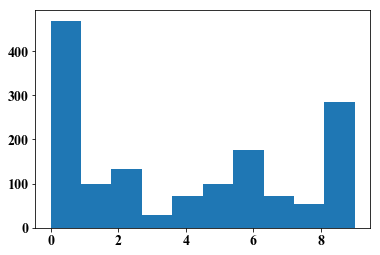

In [91]:
plt.hist(best_dims)

In [92]:
# TODO save as python object (or json)

In [93]:
# def save_transformation_dicts(transformations={}, dn='', v=0):
#     for genre_A, sub_dict in transformations.items():
#         # sub_dict :: {'genre_B_2/genre_B_2': vector}
#         a1, a2 = genre_A.split('/')
#         if a1 not in os.listdir(dn): os.mkdir(dn + a1)
#         if v:
#             print(genre_A)
#             print(sub_dict.keys())
#         io.save_dict(dn + a1, a2, sub_dict)

fn = config.plots_dir + 'transformations-best_dims.pkl'
io.save(best_dims, fn)

fn = config.plots_dir + 'transformations.pkl'
io.save(transformations, fn)

fn = config.plots_dir + 'min_transformations.pkl'
io.save(min_transformations, fn)

'../results/min_transformations.pkl'

In [94]:
t_ = io.load(fn)

In [95]:
# transformations = io.read_categorical_dict_dir(config.plots_dir + 'transformations/')
# min_transformations = io.read_categorical_dict_dir(config.plots_dir + 'min_transformations/') 

In [96]:
list(transformations.keys())[:3]

['04 Country/01 Calvin 148BPM',
 "01 Rock'n'Roll/07 Thwag 170BPM",
 '03 Traditional Pop/07 Lester Lee 133BPM']

In [97]:
len(transformations.keys())

71

In [98]:
i = 0
for v in transformations.values():
#     print(len(list(v.keys())))
    i += len(list(v.keys()))
#     i += len(list(v.values()))
i

1491